In [59]:
import math
import numpy as np
from ambiance import Atmosphere
import matplotlib.pyplot as plt
from sympy import *
import json

%matplotlib inline

# Defining atmospheric conditions with a function
def ambient_props(altitude_meters):
    atmosphere = Atmosphere(altitude_meters)
    rho = atmosphere.density
    nu = atmosphere.kinematic_viscosity
    T = atmosphere.temperature
    g = atmosphere.grav_accel

    return rho, nu, T, g

# Import all the variables
altitude = 0.00 # ASL in metres 
altitide_cruise = 4000.00 # ASL in metres 
## Do not change the following ______________________:)
air = ambient_props(altitude)
rho, nu , T, g = air[0], air[1], air[2], air[3]
## __________________________________________________:)

## CONSTRAINT DIAGRAM

In [60]:
# Variable Space for Constraint Diagram
W_P_para = np.linspace(0, 2.00, 501)
W_S_para = np.linspace(1, 300, 2001)

##### Main Global Variables
These are mainly derived from the requirements. Always subject to change

In [61]:
# Freestream
V = 22.0 # Airspeed Cruise
V_s = 15.0 # Stall Speed
q = 0.5 * rho * V**2
n_p = 0.85 # Propeller Efficiency. Usually ranges from 0.7 - 0.85
V_max = 1.3 * V     # V_maximum required. NOTE this is note the same as cruise speed but is a requirement.

# Mass and weight
m_to = 13.5       # mass of the aircraft [kg]

# Geometric
AR = 10

Aerodynamics related variables

In [62]:
# Some global variables for functions
# Aerodynamic Related
C_L_max = 1.4 # Maximum Lift coefficient
C_D_0 = 0.035 # For microlight, range-> 0.02-0.035
L_D_max = 14

Following are derived quantites, no need to change these:

In [63]:
W = m_to*9.81
mtow_rfp = m_to * ambient_props(0)[3]
e = 0.85
k = 1 / (math.pi * e * AR)

In [64]:
# Define all the functions

def stall_constraint():
    """
    Equation for stall constraint
    -----------------------------
    OUTPUT
    W_S
    """
    W_S_stall = 0.5 * rho * C_L_max * V_s**2
    return W_S_stall


def v_max_constraint(W_S):
    """
    Equation for maximum speed for the constraint diagram
    -----------------------------
    OUTPUT
    W_P_vmax
    """
    a = math.sqrt(1.4 * 287 * air[2][0]) # speed of sound at guven conditions 
    alt_mtl = 250
    rho_0 = ambient_props(0)[0]
    rho_1 = ambient_props(alt_mtl)[0]
    #sigma = 0.970725
    sigma_vmax = (1 - 1.6873e-6 * alt_mtl)**(4.26)
    W_P_vmax = (n_p) / ( (0.5 * rho_0 * V_max**3 *C_D_0* (1 / W_S)) + (((2 * k) / (rho_1 * sigma_vmax * V_max)) * (W_S)) )

    return W_P_vmax

def roc_constraint(W_S):
    """
    Equation for rate of climb for the constraint diagram
    -----------------------------
    OUTPUT
    W_P_ROC
    """
    ROC = 5 # Rate of climb :)
    rho_0 = ambient_props(0)[0]
    sq_1 =  rho_0 * np.sqrt((3 * C_D_0) / (k))
    sq_2 = np.sqrt((2 / sq_1) * W_S)
    p_3 = (1.155)/(L_D_max * n_p)
    W_P_ROC = 1 / ((ROC/n_p) + (sq_2 * p_3))

    return W_P_ROC

def cruise_constraint(W_S):
    """
    Equation for cruise for the constraint diagram
    -----------------------------
    OUTPUT
    W_P_cruise
    """
    sigma_ac = (1 - 1.6873e-6 * altitide_cruise)**(4.26)
    roc_c = 2
    rho_ac = ambient_props(altitide_cruise)[0]
    sq1 = (2) / (rho_ac * np.sqrt((3 * C_D_0)/(k)))
    sq2 = np.sqrt(sq1 * W_S)
    p3 = (1.155)/(L_D_max * n_p)
    W_P_cruise = (sigma_ac) /( (roc_c/n_p) + (sq2 * p3))

    return W_P_cruise

def bank_constraint(W_S):
    """
    Equation for banking for the constraint diagram
    -----------------------------
    OUTPUT
    W_P_bank
    """

In [65]:
# Run the functions
W_S_stall = stall_constraint()              # Stall Constraint
W_P_vmax = v_max_constraint(W_S_para)       # Maximum Speed Constraint
W_P_ROC = roc_constraint(W_S_para)          # Rate of Climb Constraint
W_P_cruise = cruise_constraint(W_S_para)    # Cruise Constraint

W_S_design = W_S_stall
W_P_design = roc_constraint(W_S_design)

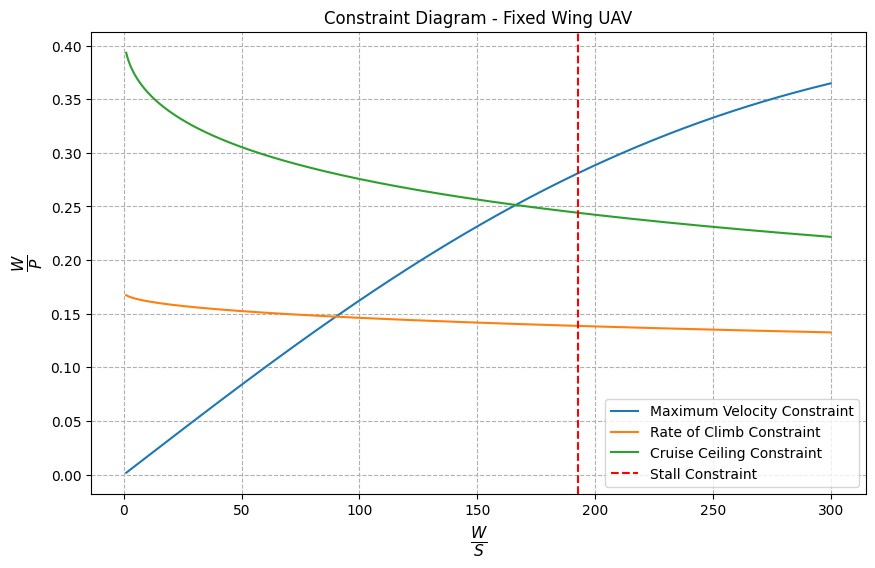

In [66]:
# Plot the constraint Diagram

plt.figure(figsize=(10,6))
plt.plot(W_S_para, W_P_vmax, label='Maximum Velocity Constraint')
plt.plot(W_S_para, W_P_ROC, label='Rate of Climb Constraint')
plt.plot(W_S_para, W_P_cruise, label='Cruise Ceiling Constraint')
plt.axvline(x=W_S_stall, color='red', linestyle='--', label='Stall Constraint')
plt.xlabel(r'$\frac{W}{S}$', fontsize=16)
plt.ylabel(r'$\frac{W}{P}$', fontsize=16)
plt.title(r'Constraint Diagram - Fixed Wing UAV')
plt.grid(True, linestyle='--')
plt.legend()
#plt.savefig(r'C:\Users\param\Concordia University - Canada\AERO 490 2023 24 - Aerodynamics\const_dia.png', format='png', dpi = 600)

In [67]:
S = W / W_S_design
P = W / W_P_design
b_design = np.sqrt(AR * S)

## Wing Design

The following parameters are required for the airfoil and wing geometry design:

1. Wing reference $S_W$ or $S_{ref}$ or $S$.
2. Vertical position of the wings.
3. Horizontal position relative to the fuselage.
4. Airfoil.
5. Aspect Ratio (AR).
6. Taper Ratio ($\lambda$).
7. Tip Chord ($C_t$).
8. Root Chord ($C_r$).
9. Mean Aerodynamics Chord (MAC or C).
10. Span (b).
11. ~~Twist Angle (or washout) ($\alpha_t$).~~
12. Sweep angle ($\Lambda$).
13. ~~Diheadral Angle ($\Tau$).~~
14. Incidence or Setting Angle ($i_w$ or $\alpha_{set}$ respectively).
15. Ailerons.
16. ~~High Lift Devices.~~
17. Other Wing Accessories.

### Airfoil Selection

The follwoing equation governs the lift requirement for the cruise phase of the flight:
$$L = W = \frac{1}{2} \rho V^2 S C_L $$



### Practical Steps for Wing Airfoil Section Selection

1. Determine the average aircraft weight ($W_{avg}$) in cruising flight.
$$W = W_{avg}$$
2. Calculate the aircraft ideal cruise lift coefficient ($C_{L_C}$) using the following station:
$$C_{L_C} = \frac{2 W_{avg}}{\rho V^2 S}$$
3. Wing Cruise Lift Coefficient
$$C_{L_{C_W}} = \frac{C_{L_C}}{0.95}$$
4. Wing airfoil ideal lift coefficient ($C_{l_{i}}$):
$$C_{l_{i}} = \frac{C_{L_{C_W}}}{0.9}$$
5. Aircraft maximum lift coefficient ($C_{L_{max}}$):
$$C_{L_{max}} = \frac{2W_{TO}}{\rho_{0} V_s^2 S}$$


In [68]:
# Refer to Sadray chapter 5 for the process.
C_L_C = (2 * W) / (ambient_props(altitide_cruise)[0] * V**2 * S)
C_L_C_W = C_L_C / 0.95
C_l_i = C_L_C_W / 0.9
C_L_maxx = (2 * W) / (ambient_props(0)[0] * V_s**2  * S )
C_L_maxx_w = C_L_maxx / 0.95

# Calculate the wing airfoil gross maximum lift coefficient
C_l_maxx_gross = C_L_maxx_w / 0.9

Since there are no high lift devices, the following relation can be established:
$$C_{l_{max}} = C_{l_{max\_gross}}$$

In [69]:
C_l_maxx = C_l_maxx_gross

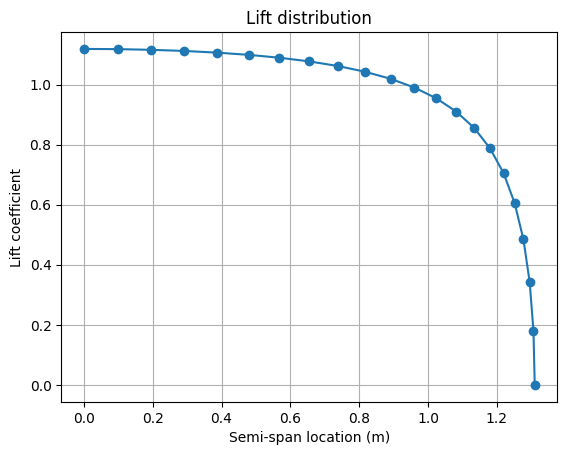

In [70]:
def lift_distribution(S, AR, taper_ratio):
    N = 21  # (number of segments - 1)
    lambda_val = taper_ratio  # Taper ratio
    alpha_twist = 0.0  # Twist angle (deg)
    i_w = 1.9  # wing setting angle (deg)
    a_2d = 6.3  # lift curve slope (1/rad)
    alpha_0 = -9.5  # zero-lift angle of attack (deg)
    b = np.sqrt(AR * S)  # wing span (m)
    MAC = S / b  # Mean Aerodynamic Chord (m)
    Croot = (1.5 * (1 + lambda_val) * MAC) / (1 + lambda_val + lambda_val ** 2)  # root chord (m)
    Ctip = Croot * lambda_val
    theta = np.linspace(np.pi / (2 * N), np.pi / 2, N)
    alpha = np.linspace(i_w + alpha_twist, i_w, num=N)
    z = (b / 2) * np.cos(theta)
    c = Croot * (1 - (1 - lambda_val) * np.cos(theta))  # Mean Aerodynamics Chord at each segment (m)
    mu = c * a_2d / (4 * b)
    LHS = mu * (alpha - alpha_0) * np.pi / 180  # Left Hand Side

    # Solving N equations to find coefficients A(i):
    B = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            B[i, j] = np.sin((2 * j + 1) * theta[i]) * (1 + (mu[i] * (2 * j + 1)) / np.sin(theta[i]))

    A = np.linalg.solve(B, LHS)

    sum1 = np.zeros(N)
    sum2 = np.zeros(N)
    for i in range(N):
        for j in range(N):
            sum1[i] += (2 * j + 1) * A[j] * np.sin((2 * j + 1) * theta[i])
            sum2[i] += A[j] * np.sin((2 * j + 1) * theta[i])

    CL = 4 * b * sum2 / c
    CL1 = np.insert(CL, 0, 0)
    y_s = np.insert(z, 0, b / 2)

    plt.plot(y_s, CL1, "-o")
    plt.grid()
    plt.title("Lift distribution")
    plt.xlabel("Semi-span location (m)")
    plt.ylabel("Lift coefficient")
    #plt.legend()
    CL_wing = np.pi * AR * A[0]

    return CL_wing, taper_ratio, Croot, Ctip, b, y_s, CL1, MAC

lift_data = lift_distribution(S, AR, 1.0)

#### Calculation of Drag 
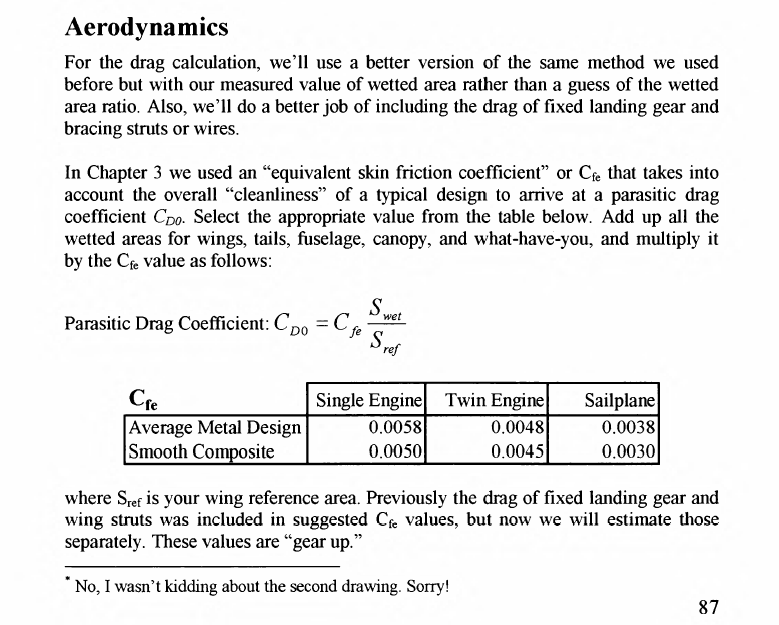

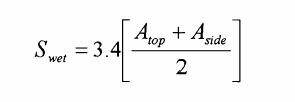

In [71]:
s_wet_cd = 3.4 * (lift_data[2] * lift_data[4]/2)
C_D_0_est = 0.0038 * (s_wet_cd / S)

In [72]:
print(" ")
print("================================================================================================")
print("RESULTS FROM WING SIZING NOTEBOOK")
print(" ")
print("Wing Geomtery Requirements__>")
print("Weigth to Surface Area Ratio: {0:1.5f}".format(*W_S_design))
print("Required Surface Area = {0:1.5f}".format(*S), "m^2")
print("Power Required = {0:1.5f}".format(*P), "watts")
print("Required Design Span = {0:1.5f}".format(*b_design), "m")
print("------------------------------------------------------------------------------------------------")
print("Wing Airfoil Net Properties__>")
print("The wing airfoil net maximum lift coefficient: {0:1.5f}".format(*C_l_maxx_gross))
print("The wing airfoil ideal lift coefficient: {0:1.5f}".format(*C_l_i))
print("------------------------------------------------------------------------------------------------")
print("Wing Geometry Results__>")
print("Wing lift coefficient: {0:1.5f}".format(lift_data[0]))
print("Root Chord (c_root): {0:1.5f}".format(*lift_data[2]), "m")
print("Tip Chord (c_tip): {0:1.5f}".format(*lift_data[3]), "m")
print("Mean Aerodynamic Chord: {0:1.5f}".format(*lift_data[7]))
print("Airfoil = fx 63-137 (13.7%)")
print("================================================================================================")
print(" ")

 
RESULTS FROM WING SIZING NOTEBOOK
 
Wing Geomtery Requirements__>
Weigth to Surface Area Ratio: 192.93750
Required Surface Area = 0.68641 m^2
Power Required = 955.32991 watts
Required Design Span = 2.61995 m
------------------------------------------------------------------------------------------------
Wing Airfoil Net Properties__>
The wing airfoil net maximum lift coefficient: 1.63743
The wing airfoil ideal lift coefficient: 1.13807
------------------------------------------------------------------------------------------------
Wing Geometry Results__>
Wing lift coefficient: 1.00636
Root Chord (c_root): 0.26200 m
Tip Chord (c_tip): 0.26200 m
Mean Aerodynamic Chord: 0.26200
Airfoil = fx 63-137 (13.7%)
 


In [73]:
# Writing the data to the be accessed in other files
data = [
    ["W_S", "{0:1.5f}".format(*W_S_design)],
    ["S_req", "{0:1.5f}".format(*S)],
    ["P_req", "{0:1.5f}".format(*P)],
    ["b_req", "{0:1.5f}".format(*b_design)],
    ["C_L_max", "{0:1.5f}".format(*C_l_maxx_gross)],
    ["C_L_i", "{0:1.5f}".format(*C_l_i)],
    ["C_L_design", "{0:1.5f}".format(lift_data[0])],
    ["C_root", "{0:1.5f}".format(*lift_data[2])],
    ["C_tip", "{0:1.5f}".format(*lift_data[3])],
    ["MAC", "{0:1.5f}".format(*lift_data[7])],
    ["AR", "{0:1.5f}".format(AR)],
    ["m_to", "{0:1.5f}".format(m_to)],
    ["V", "{0:1.5f}".format(V)],
    ["V_s", "{0:1.5f}".format(V_s)],
    ["V_max", "{0:1.5f}".format(V_max)],
    ["altitude_cruise", "{0:1.5f}".format(altitide_cruise)]
]  
data_dict = {item[0]: item[1] for item in data}
with open("reports\wing_sizing_res.json", "w") as f:
    json.dump(data_dict, f)